# 1 Load Config and Network

In [1]:
%load_ext autoreload
%autoreload 2
# %cd /p/mmcardiac/Jerry/code/CINE-DENSE-Translation
# %cd /home/jx8fh/Projects/LaMoD
%cd /workspace/LaMoD
import numpy as np
import torch
import matplotlib.pyplot as plt
from pathlib import Path
from modules.data import check_dict

/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD


In [2]:
# USE GPU 0
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
import json
config_fname = 'configs/ours-LaMoD.json'
config = json.load(open(config_fname))

In [4]:
from models.LaMoD import LaMoD
network = LaMoD(config['networks'], device).to(device)

Skip connect: False
Loading pretrained model from checkpoints/ours_registration.pth
Unrecognized keyword argument: beta_schedule_overwrite = True
Unrecognized keyword argument: load_pretrained = True
Unrecognized keyword argument: pretrained_model_path = checkpoints/ours_latent_diffusion.pth
beta_schedule_method='linear'
Loading pretrained model from checkpoints/ours_latent_diffusion.pth


/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Overwriting beta schedule with linear schedule with scale 30
ignorekwargs: {'type': 'DiffusionDecoder', 'drouput': 0.3, 'load_pretrained': True, 'pretrained_model_path': 'checkpoints/ours_motion_regression.pth'}
Decoder tanh_out:  False
Decoder: give_pre_end=False, tanh_out=False, out_scaling_factor=1
Working with z of shape (1, 16, 16, 16) = 4096 dimensions.
making attention of type 'vanilla' with 256 in_channels
making attention of type 'vanilla' with 256 in_channels
making attention of type 'vanilla' with 256 in_channels
making attention of type 'vanilla' with 256 in_channels
making attention of type 'vanilla' with 128 in_channels
making attention of type 'vanilla' with 128 in_channels
making attention of type 'vanilla' with 128 in_channels
making attention of type 'vanilla' with 64 in_channels
making attention of type 'vanilla' with 64 in_channels
making attention of type 'vanilla' with 64 in_channels
Loading pretrained model from checkpoints/ours_motion_regression.pth


# 2 CINE Prediction

In [10]:
cine_DENSE_fname = '/scratch/jx8fh/2024-04-21-matched-cine-DENSE-from-Yu-all-with-resampled.npy'
cine_DENSE_data = np.load(cine_DENSE_fname, allow_pickle=True).tolist()

In [11]:
print(f"length of data: {len(cine_DENSE_data)}")
check_dict(cine_DENSE_data[0])

length of data: 105
AnalysisInfo                                                 dict_keys(['ResampleMethod', 'ResampleDistance', 'SpatialSmoothing', 'TemporalOrder', 'Xseed', 'Yseed', 'Zseed', 'FramesForAnalysis', 'Nmodel', 'PositionA', 'PositionB', 'Clockwise'])
AnalysisInstanceUID                                          1.3.6.1.4.1.9590.100.1.2.64946301013757307506911904523491151334
DENSEInfo                                                    dict_keys(['Name', 'UID', 'Type', 'MagIndex', 'PhaIndex', 'Number', 'PixelSpacing', 'Scale', 'EncFreq', 'SwapFlag', 'NegFlag'])
DENSE_Eul_displacement_field_Multipliers                     (3,)                
DENSE_Eul_displacement_field_X                               (48, 48, 51)        
DENSE_Eul_displacement_field_Y                               (48, 48, 51)        
DENSE_Lag_displacement_field_X                               (48, 48, 51)        
DENSE_Lag_displacement_field_Y                               (48, 48, 51)        
DENSE_frame

In [18]:
from modules.data.processing.strain_analysis.pixelstrain import pixelstrain
from modules.data.processing.strain_analysis.resample_strain_matrix import resample_strain_matrix_2d
from modules.data.processing.strain_analysis.six_segments_core import six_segments_core, get_various_segmental_strain_data
from skimage.transform import resize
from skimage.morphology import dilation, disk, closing
import tqdm
# check_data_idx = 0
n_repeats = 5
my_pred_disps = []
skip_diffusion = True
cine_save_pred_dir = Path('/scratch/jx8fh/2025-01-04-LaMoD-variability/cine')
for check_data_idx, check_datum in tqdm.tqdm(enumerate(cine_DENSE_data)):    
    # Get the raw mask
    inference_mask_raw = torch.from_numpy(
            resize(check_datum['cine_cropped_myocardium_masks_rescaled_1mm2'][...,0]>0.5, [48,48], anti_aliasing=False)
        )    
    # Get the dilated mask since the pixelstrain function refuse to compute when a pixel has few neighbors
    inference_mask = torch.from_numpy(dilation(inference_mask_raw, disk(2)))
    
    # Prepare Pytorch tensor
    inference_input_video      = torch.from_numpy(check_datum['cine_cropped_myocardium_masks_rescaled_1mm2']).to(device).moveaxis(-1,0)[None, None]
    # inference_input_video_ori_frame = check_datum['ori_n_frames']
    inference_input_video_ori_frame = inference_input_video.shape[2]

    patient_repeats = []
    for repeat_idx in range(n_repeats):    
        inference_output_dict = network.inference(
            inference_input_video, 
            ori_n_frames=[inference_input_video_ori_frame],
            skip_diffusion=False)[0]
        # Extract prediction
        inference_disp = inference_output_dict['LaMoD_disp'].detach().cpu() / 2.73

        # Compute the strain 
        H, W = inference_disp.shape[-2:]
        X, Y = np.meshgrid(np.arange(W), np.arange(H))
        dXt = np.moveaxis(inference_disp[0,0].numpy(), 0, -1)
        dYt = np.moveaxis(inference_disp[0,1].numpy(), 0, -1)
        mask = inference_mask.numpy()
        Nfr = inference_disp.shape[2]
        strain = pixelstrain(
            X=X, Y=Y, 
            dXt=dXt, dYt=dYt, 
            mask=mask, times=np.arange(Nfr))
        strainCC = strain['CC']

        # re-compute the GT strain to make sure the prediction and GT share the sanme strain computation method
        mask_GT = (np.abs(check_datum['DENSE_Lag_displacement_field_X'][...,0]) + np.abs(check_datum['DENSE_Lag_displacement_field_Y'][...,0])) > 0
        Nfr_DENSE = check_datum['DENSE_Lag_displacement_field_X'].shape[2]
        cine_strain_GT = pixelstrain(
            X=X, Y=Y, 
            dXt=check_datum['DENSE_Lag_displacement_field_X'], 
            dYt=check_datum['DENSE_Lag_displacement_field_Y'], 
            mask=mask_GT, times=np.arange(Nfr_DENSE))
        
        # Compute segmental strain
        cine_recompute_strain = get_various_segmental_strain_data(
            strain_images=strain['CC'], 
            strain_mask=~np.isnan(strain['CC'][...,0]), 
            origin=np.array([24,24]), 
            # insertion=np.array([24,0]),
            insertion=check_datum['cine_rv_insertion_points_rescaled_DENSE48'],
            enable_offset=True,
            offset_degrees=[90, 120, 120],
            generate_layerid_map=False)

        cine_datum_n_valid_frames = Nfr
        cine_DENSE_time_stamps = check_datum['DENSE_frame_time_stamps']
        cine_time_stamps = check_datum['cine_frame_time_stamps'][:cine_datum_n_valid_frames]
        
        cine_DENSE_strain_imgs = strain_GT['CC']
        cine_DENSE_strain_mask = np.abs(check_datum['DENSE_Lag_displacement_field_X'][...,0])>1e-5
        cine_DENSE_origin = check_datum['AnalysisInfo']['PositionA'] - np.array([check_datum['DENSE_myo_mask_bbox'][2], check_datum['DENSE_myo_mask_bbox'][0]])
        cine_DENSE_insertion = check_datum['AnalysisInfo']['PositionB'] - np.array([check_datum['DENSE_myo_mask_bbox'][2], check_datum['DENSE_myo_mask_bbox'][0]])
        cine_DENSE_recompute_strain = get_various_segmental_strain_data(
            cine_DENSE_strain_imgs, 
            cine_DENSE_strain_mask, 
            cine_DENSE_origin, 
            cine_DENSE_insertion,
            layerid_map = None,
            generate_layerid_map=True)
        
        for strainmat_name in ['CCs4', 'CCs6', 'CCs18']:
            cine_DENSE_recompute_strain[strainmat_name+'Resampled'] = resample_strain_matrix_2d(cine_DENSE_recompute_strain[strainmat_name], cine_DENSE_time_stamps, cine_time_stamps)
            cine_recompute_strain[strainmat_name+'Resampled'] = resample_strain_matrix_2d(cine_recompute_strain[strainmat_name], cine_time_stamps, cine_DENSE_time_stamps)

        # compute the masked displacement field
        inference_disp_masked = inference_disp.clone()
        inference_disp_masked[~inference_mask] = 0
        
        # Save to file        
        # cine_save_pred_dir.mkdir(exist_ok=True, parents=True)
        save_dict = {
            'disp_GT': np.concatenate((check_datum['DENSE_Lag_displacement_field_X'][None], check_datum['DENSE_Lag_displacement_field_Y'][None]), axis=0), # [2, H, W, Nfr]
            'disp_pred': np.moveaxis(inference_disp.numpy()[0], 1, -1),
            'strain_GT': cine_DENSE_strain_imgs,
            'strain_pred': strain['CC']
            }
        for strainmat_name in cine_recompute_strain.keys():
            save_dict[strainmat_name+'_pred'] = cine_recompute_strain[strainmat_name]
        for strainmat_name in cine_DENSE_recompute_strain.keys():
            save_dict[strainmat_name+'_GT'] = cine_DENSE_recompute_strain[strainmat_name]
        
        patient_repeats.append(save_dict)
    
    # save file
    patient_id = check_datum['patient_id']
    save_path = cine_save_pred_dir / f'LaMoD-cine-{patient_id}.npy'
    np.save(save_path, patient_repeats)
    break

0it [00:22, ?it/s]


# DENSE

In [5]:
# test_DENSE_data = np.load('/p/mmcardiac/Jerry/code/CINE-DENSE-Translation/data/DENSE/2024-04-16-test-data.npy', allow_pickle=True).tolist()
test_DENSE_data = np.load('/scratch/jx8fh/2024-04-16-test-data.npy', allow_pickle=True).tolist()
# test_DENSE_data = np.load('/scratch/jx8fh/2024-06-22-MICCAI-ShapeMI-Workshop-data/lamod_test.npy', allow_pickle=True).tolist()
print(f"len(test_DENSE_data) = {len(test_DENSE_data)}")
check_dict(test_DENSE_data[0])

len(test_DENSE_data) = 102
patient_id                                                   033                 
DENSE_slice_mat_filename                                     /p/miauva/data/Jerry/medical-images/Cardiac-FromKen/Yu-DENSE-data/033_S01_base_auto.1_ROI.1.mat
DENSE_slice_location                                         76.947609505431     
DENSE_frame_time_stamps                                      (51,)               
DENSE_Lag_displacement_field_X                               (48, 48, 51)        
DENSE_Lag_displacement_field_Y                               (48, 48, 51)        
DENSE_myo_masks                                              (48, 48, 51)        
DENSE_myo_mask_bbox                                          (34, 82, 40, 88)    
DENSE_myo_masks_rescaled                                     (128, 128, 51)      
DENSE_n_frames_all                                           51                  
DENSE_frame_indices_with_myo_contour                         (51,)            

In [6]:
# count the number of files under /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE
# ls -l /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE | grep -c ^-

In [7]:
from modules.data.processing.strain_analysis.pixelstrain import pixelstrain
from modules.data.processing.strain_analysis.resample_strain_matrix import resample_strain_matrix_2d
from modules.data.processing.strain_analysis.six_segments_core import six_segments_core, get_various_segmental_strain_data
from skimage.transform import resize
from skimage.morphology import dilation, disk, closing
import tqdm
# check_data_idx = 0
n_repeats = 1
my_pred_disps = []
skip_diffusion = True        
DENSE_save_pred_dir = Path('/scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE')

for check_data_idx, check_datum in tqdm.tqdm(enumerate(test_DENSE_data)):    
    # Get the mask
    # inference_mask = torch.from_numpy(check_datum['DENSE_myo_masks'][...,0])
    mask_GT = (np.abs(check_datum['DENSE_Lag_displacement_field_X'][...,0]) + np.abs(check_datum['DENSE_Lag_displacement_field_Y'][...,0])) > 0
    inference_mask = torch.from_numpy(mask_GT)
    
    # Prepare Pytorch tensor
    inference_input_video      = torch.from_numpy(check_datum['DENSE_myo_masks_rescaled']).to(device).moveaxis(-1,0)[None, None]
    # inference_input_video_ori_frame = check_datum['ori_n_frames']
    inference_input_video_ori_frame = inference_input_video.shape[2]

    patient_repeats = []
    for repeat_idx in range(n_repeats):        
        inference_output_dict = network.inference(
            inference_input_video, 
            ori_n_frames=[inference_input_video_ori_frame],
            # skip_diffusion=False)[0]
            skip_diffusion=True)[0]
        # Extract prediction
        inference_disp = inference_output_dict['LaMoD_disp'].detach().cpu() / 2.73

        # Compute the strain 
        H, W = inference_disp.shape[-2:]
        X, Y = np.meshgrid(np.arange(W), np.arange(H))
        dXt = np.moveaxis(inference_disp[0,0].numpy(), 0, -1)
        dYt = np.moveaxis(inference_disp[0,1].numpy(), 0, -1)
        mask = inference_mask.numpy()
        Nfr = inference_disp.shape[2]
        strain = pixelstrain(
            X=X, Y=Y, 
            dXt=dXt, dYt=dYt, 
            mask=mask, times=np.arange(Nfr))
        strainCC = strain['CC']

        # re-compute the GT strain to make sure the prediction and GT share the sanme strain computation method
        
        Nfr_GT = check_datum['DENSE_Lag_displacement_field_X'].shape[2]
        strain_GT = pixelstrain(
            X=X, Y=Y, 
            dXt=check_datum['DENSE_Lag_displacement_field_X'], 
            dYt=check_datum['DENSE_Lag_displacement_field_Y'], 
            mask=mask_GT, times=np.arange(Nfr_GT))
        
        # Compute segmental strain
        DENSE_origin = check_datum['AnalysisInfo']['PositionA'] - np.array([check_datum['DENSE_myo_mask_bbox'][2], check_datum['DENSE_myo_mask_bbox'][0]])
        DENSE_insertion = check_datum['AnalysisInfo']['PositionB'] - np.array([check_datum['DENSE_myo_mask_bbox'][2], check_datum['DENSE_myo_mask_bbox'][0]])
        recompute_strain = get_various_segmental_strain_data(
            strain_images=strain['CC'], 
            strain_mask=~np.isnan(strain['CC'][...,0]), 
            origin=DENSE_origin, 
            # insertion=np.array([24,0]),
            insertion=DENSE_insertion,
            enable_offset=False,
            offset_degrees=[90, 120, 120],
            generate_layerid_map=False)

        datum_n_valid_frames = Nfr
        DENSE_time_stamps = check_datum['DENSE_frame_time_stamps']
        # time_stamps = check_datum['cine_frame_time_stamps'][:cine_datum_n_valid_frames]
        
        DENSE_strain_imgs = strain_GT['CC']
        DENSE_strain_mask = np.abs(check_datum['DENSE_Lag_displacement_field_X'][...,0])>1e-5        
        DENSE_recompute_strain = get_various_segmental_strain_data(
            DENSE_strain_imgs, 
            DENSE_strain_mask, 
            DENSE_origin, 
            DENSE_insertion,
            layerid_map = None,
            generate_layerid_map=True)
        
        # for strainmat_name in ['CCs4', 'CCs6', 'CCs18']:
        #     DENSE_recompute_strain[strainmat_name+'Resampled'] = resample_strain_matrix_2d(DENSE_recompute_strain[strainmat_name], DENSE_time_stamps, cine_time_stamps)
        #     recompute_strain[strainmat_name+'Resampled'] = resample_strain_matrix_2d(cine_recompute_strain[strainmat_name], cine_time_stamps, DENSE_time_stamps)

        # Compose the dictionary and save to file
        # DENSE_input_save_pred_dir = Path('debug/notebooks/2025-01-01-LaMoD-variability-cine')
        # cine_save_pred_dir.mkdir(exist_ok=True, parents=True)

        # compute the masked displacement field
        inference_disp_masked = inference_disp * inference_mask[None]

        save_dict = {
            'disp_GT': np.concatenate((check_datum['DENSE_Lag_displacement_field_X'][None], check_datum['DENSE_Lag_displacement_field_Y'][None]), axis=0), # [2, H, W, Nfr]
            'disp_pred': np.moveaxis(inference_disp_masked.numpy()[0], 1, -1),
            'disp_mask': inference_mask.numpy(),
            'strain_GT': DENSE_strain_imgs,
            'strain_pred': strain['CC'],            
            }
        for strainmat_name in recompute_strain.keys():
            save_dict[strainmat_name+'_pred'] = recompute_strain[strainmat_name]
        for strainmat_name in DENSE_recompute_strain.keys():
            save_dict[strainmat_name+'_GT'] = DENSE_recompute_strain[strainmat_name]
        
        patient_repeats.append(save_dict)
    
    # save file
    patient_id = check_datum['patient_id']
    datum_slide_location = check_datum['DENSE_slice_location']
    save_path = DENSE_save_pred_dir / f'LaMoD-DENSE-SkipDiffusion-{check_data_idx:03d}-{patient_id}-{int(np.floor(datum_slide_location))}.npy'
    np.save(save_path, patient_repeats)
    print(f'Save to {save_path}')
    # break

1it [00:10, 10.29s/it]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-000-033-76.npy


2it [00:12,  5.67s/it]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-001-033-86.npy


3it [00:14,  4.09s/it]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-002-033-105.npy


4it [00:17,  3.40s/it]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-003-033-115.npy


/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: divide by zero encountered in divide
  ret = um.true_divide(
/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
5it [00:18,  2.61s/it]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-004-122--62.npy


6it [00:19,  2.05s/it]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-005-122--71.npy


7it [00:20,  1.64s/it]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-006-122--91.npy


8it [00:21,  1.49s/it]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-007-124-27.npy


9it [00:22,  1.31s/it]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-008-124-37.npy


10it [00:23,  1.21s/it]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-009-124-47.npy


11it [00:24,  1.12s/it]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-010-124-56.npy


12it [00:26,  1.36s/it]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-011-125-55.npy


13it [00:27,  1.33s/it]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-012-125-75.npy


14it [00:28,  1.40s/it]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-013-125-84.npy


15it [00:30,  1.35s/it]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-014-125-103.npy


16it [00:31,  1.41s/it]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-015-136--73.npy


17it [00:32,  1.30s/it]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-016-136--82.npy


18it [00:33,  1.21s/it]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-017-136--92.npy


19it [00:34,  1.16s/it]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-018-136--101.npy


20it [00:35,  1.01s/it]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-019-146--77.npy


21it [00:36,  1.12it/s]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-020-146--86.npy


22it [00:36,  1.26it/s]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-021-146--106.npy


23it [00:37,  1.32it/s]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-022-146--115.npy


24it [00:38,  1.29it/s]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-023-17-11.npy


25it [00:39,  1.24it/s]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-024-17--10.npy


26it [00:39,  1.26it/s]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-025-17--78.npy


27it [00:40,  1.18it/s]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-026-CRT104-57.npy


28it [00:41,  1.14it/s]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-027-CRT104-66.npy


29it [00:42,  1.12it/s]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-028-CRT104-76.npy


30it [00:43,  1.21it/s]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-029-CT01-62.npy


31it [00:43,  1.35it/s]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-030-CT01-82.npy


32it [00:44,  1.61it/s]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-031-CT01-102.npy


33it [00:44,  1.65it/s]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-032-CT03-127.npy


34it [00:45,  1.68it/s]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-033-CT03-127.npy


35it [00:45,  1.81it/s]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-034-CT03-137.npy


36it [00:46,  1.75it/s]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-035-CT22-70.npy


37it [00:47,  1.68it/s]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-036-CT22-90.npy


38it [00:47,  1.82it/s]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-037-CT22-110.npy


39it [00:48,  1.72it/s]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-038-CT40--80.npy


40it [00:48,  1.72it/s]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-039-CT40--100.npy


41it [00:49,  1.74it/s]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-040-CT40--120.npy


42it [00:53,  1.70s/it]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-041-Emory_04--94.npy


43it [00:57,  2.28s/it]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-042-Emory_04--107.npy


44it [01:00,  2.51s/it]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-043-Emory_04--126.npy


45it [01:04,  2.99s/it]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-044-Emory_06-34.npy


46it [01:08,  3.19s/it]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-045-Emory_06-43.npy


47it [01:11,  3.14s/it]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-046-Emory_06--61.npy


48it [01:13,  3.05s/it]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-047-Emory_07-24.npy


49it [01:16,  2.99s/it]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-048-Emory_07--38.npy


50it [01:18,  2.75s/it]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-049-Emory_07--48.npy


51it [01:20,  2.50s/it]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-050-Lyon69_ene_al--53.npy


52it [01:22,  2.32s/it]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-051-Lyon69_ene_al--67.npy


53it [01:24,  2.14s/it]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-052-Lyon69_ene_al--81.npy


54it [01:27,  2.32s/it]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-053-Lyon_Cha_Jea-47.npy


55it [01:29,  2.37s/it]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-054-Lyon_Cha_Jea-89.npy


56it [01:31,  2.08s/it]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-055-Lyon_Ene_Alex--38.npy


57it [01:32,  1.88s/it]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-056-Lyon_Ene_Alex--52.npy


58it [01:33,  1.69s/it]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-057-Lyon_Ene_Alex--66.npy


59it [01:35,  1.71s/it]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-058-Lyon_d04_scanA--46.npy


60it [01:37,  1.72s/it]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-059-Lyon_d04_scanA--18.npy


61it [01:39,  1.97s/it]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-060-Lyon_d04_scanA--32.npy


62it [01:40,  1.59s/it]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-061-OB015-37.npy


63it [01:41,  1.29s/it]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-062-OB015-77.npy


64it [01:41,  1.04s/it]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-063-OB016-13.npy


65it [01:42,  1.14it/s]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-064-OB016-39.npy


66it [01:42,  1.34it/s]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-065-OB017-25.npy


67it [01:42,  1.59it/s]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-066-OB017-39.npy


68it [01:43,  1.78it/s]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-067-OB018-94.npy


69it [01:43,  1.78it/s]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-068-OB018-60.npy


70it [01:44,  1.81it/s]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-069-OB018-77.npy


71it [01:45,  1.76it/s]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-070-OB019--56.npy


72it [01:45,  1.62it/s]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-071-OB019--40.npy


73it [01:47,  1.23it/s]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-072-P117-50.npy


74it [01:48,  1.07s/it]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-073-P117-60.npy


75it [01:50,  1.26s/it]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-074-P117-69.npy


76it [01:51,  1.30s/it]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-075-P117-79.npy


77it [01:53,  1.37s/it]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-076-StFrancis_DENSE10A--39.npy


78it [01:55,  1.47s/it]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-077-StFrancis_DENSE10A--23.npy


79it [01:56,  1.35s/it]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-078-StFrancis_DENSE11A-13.npy


80it [01:57,  1.23s/it]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-079-StFrancis_DENSE11A-29.npy


81it [01:57,  1.14s/it]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-080-StFrancis_DENSE11A-45.npy


82it [02:00,  1.56s/it]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-081-UVA_04--106.npy


83it [02:02,  1.75s/it]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-082-UVA_04--125.npy


84it [02:04,  1.74s/it]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-083-UVA_04--144.npy


85it [02:05,  1.66s/it]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-084-UVA_05192021-57.npy


86it [02:07,  1.68s/it]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-085-UVA_05192021-76.npy


87it [02:09,  1.68s/it]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-086-UVA_05192021-96.npy


88it [02:11,  1.78s/it]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-087-UVA_05--77.npy


89it [02:13,  1.81s/it]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-088-UVA_05--93.npy


90it [02:14,  1.76s/it]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-089-UVA_05--109.npy


91it [02:16,  1.75s/it]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-090-UVA_07-12.npy


92it [02:18,  1.71s/it]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-091-UVA_07-28.npy


93it [02:19,  1.72s/it]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-092-UVA_07-44.npy


94it [02:21,  1.59s/it]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-093-UVA_08_A_U1-18.npy


95it [02:22,  1.48s/it]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-094-UVA_08_A_U1-34.npy


96it [02:23,  1.45s/it]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-095-UVA_08_A_U1-50.npy


97it [02:25,  1.47s/it]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-096-UVA_09_A_U1--21.npy


98it [02:26,  1.50s/it]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-097-UVA_09_A_U1--37.npy


99it [02:28,  1.45s/it]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-098-UVA_09_A_U1--53.npy


100it [02:29,  1.44s/it]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-099-UVA_11_A_U1--55.npy


101it [02:31,  1.42s/it]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-100-UVA_11_A_U1--79.npy


102it [02:31,  1.49s/it]

Save to /scratch/jx8fh/2025-01-04-LaMoD-variability/DENSE/LaMoD-DENSE-SkipDiffusion-101-UVA_11_A_U1--103.npy


In [10]:
check_dict(check_datum)

patient_id                                                   033                 
DENSE_slice_mat_filename                                     /p/miauva/data/Jerry/medical-images/Cardiac-FromKen/Yu-DENSE-data/033_S03_auto.3_mid2_ROI.3.mat
DENSE_slice_location                                         105.74763877719     
DENSE_frame_time_stamps                                      (51,)               
DENSE_Lag_displacement_field_X                               (48, 48, 51)        
DENSE_Lag_displacement_field_Y                               (48, 48, 51)        
DENSE_myo_masks                                              (48, 48, 51)        
DENSE_myo_mask_bbox                                          (30, 78, 39, 87)    
DENSE_myo_masks_rescaled                                     (128, 128, 51)      
DENSE_n_frames_all                                           51                  
DENSE_frame_indices_with_myo_contour                         (51,)               
out_of_box_flag        

In [21]:
inference_disp_masked = inference_disp * inference_mask[None]

In [22]:
inference_disp_masked.shape

torch.Size([1, 2, 56, 48, 48])

In [26]:
check_datum['DENSE_Lag_displacement_field_X'][None].shape

(1, 48, 48, 57)

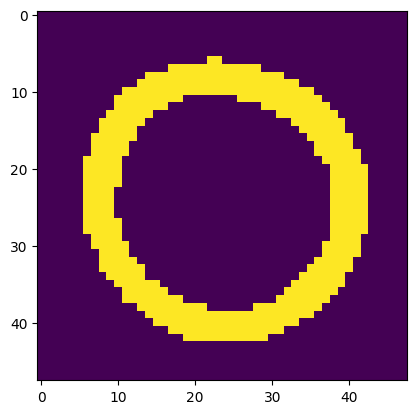

In [41]:
plt.imshow(inference_mask)

In [ ]:
plt.imshow(DENSE_strain_mask)

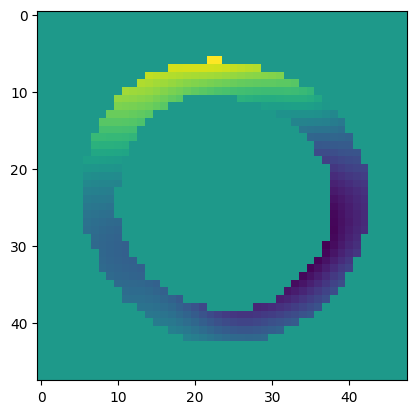

In [37]:
plt.imshow(check_datum['DENSE_Lag_displacement_field_X'][None][0,...,30])

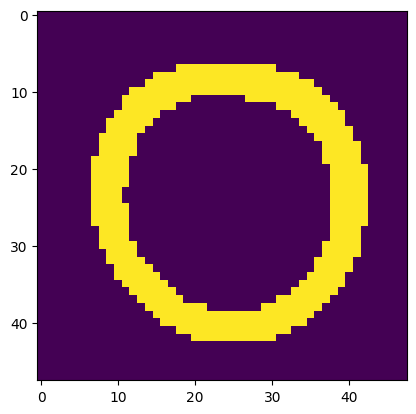

In [38]:
plt.imshow(check_datum['DENSE_myo_masks'][...,0])

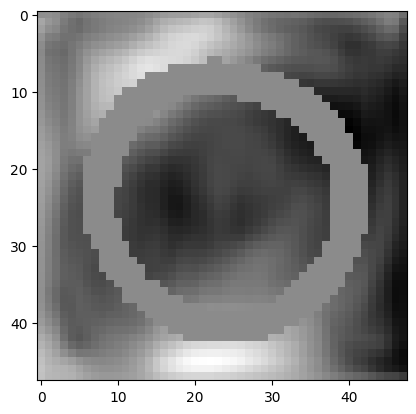

In [39]:
plt.imshow(inference_disp[0,0,10] - inference_disp_masked[0,0,10], cmap='gray')

In [14]:
print(DENSE_origin)
print(DENSE_insertion)

[25.31962217 25.24238535]
[14.3796845   9.85869309]


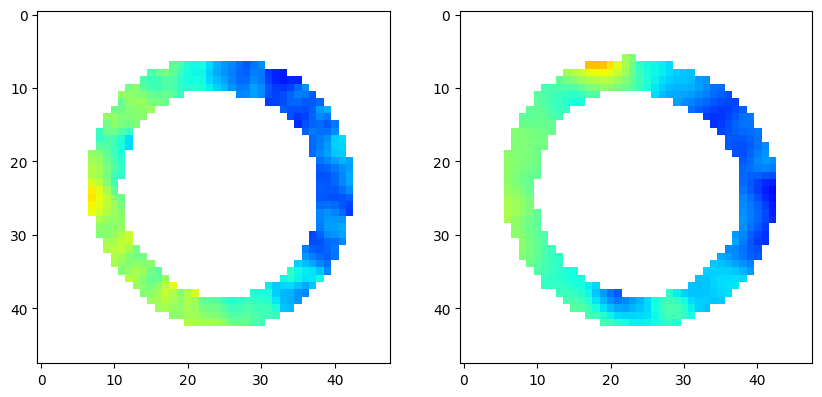

In [15]:
check_frame_idx = 30
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].imshow(strain['CC'][...,check_frame_idx], cmap='jet', vmin=-0.2, vmax=0.2)
axs[1].imshow(strain_GT['CC'][...,check_frame_idx], cmap='jet', vmin=-0.2, vmax=0.2)

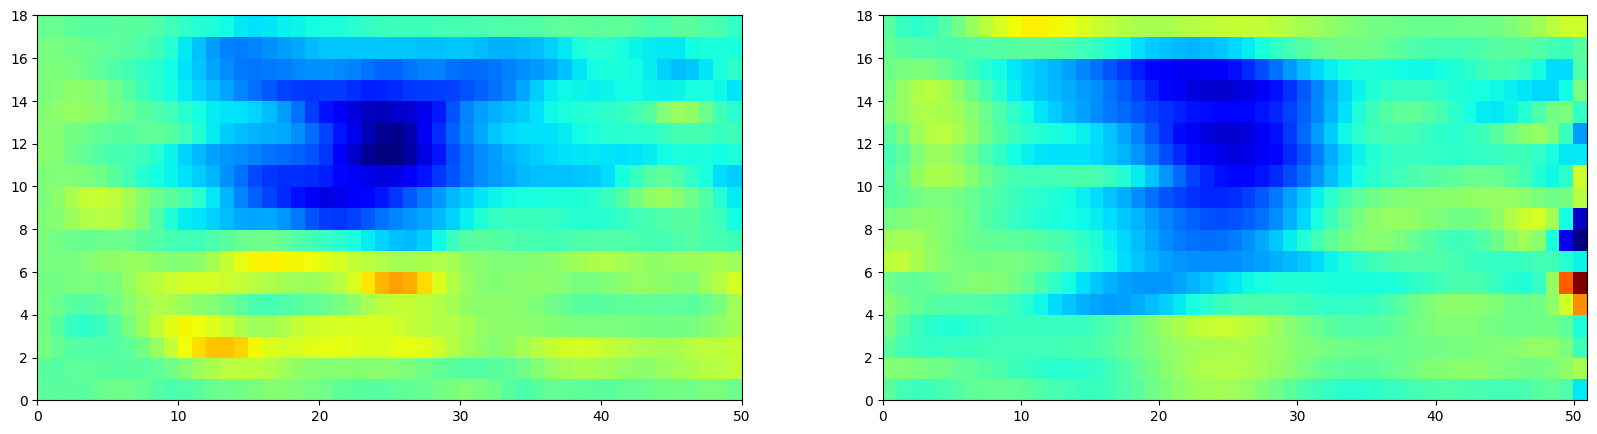

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
axs[0].pcolor(recompute_strain['CCs18'], cmap='jet', vmin=-0.2, vmax=0.2)
axs[1].pcolor(DENSE_recompute_strain['CCs18'], cmap='jet', vmin=-0.2, vmax=0.2)